In [1]:
import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
import sklearn
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy
import random
from sktime.forecasting.all import temporal_train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from prophet.plot import plot_plotly
import plotly.offline as py
import plotly.graph_objs as go
import copy
import matplotlib.pyplot as plt

from prophet.plot import plot_plotly
import pandas as pd
##from util_prophet import *
#from fbprophet import Prophet
from prophet import Prophet

warnings.filterwarnings('ignore')

/home/scarlettzsj/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

data_co2=pd.read_csv(r'/home/scarlettzsj/ATMS523FINALPROJECT/data_co2.csv')
data_temp=pd.read_csv(r'/home/scarlettzsj/ATMS523FINALPROJECT/temp.csv')
data_co2.head(10)

,ds,co2
0,1958-03-15,315.700
1,1958-04-15,317.450
2,1958-05-15,317.510
3,1958-06-15,316.685
4,1958-07-15,315.860
5,1958-08-15,314.930
6,1958-09-15,313.200
7,1958-10-15,313.265
8,1958-11-15,313.330
9,1958-12-15,314.670


In [3]:

# Assuming data_co2['ds'] is a pandas Series with datetime objects
data_co2['ds'] = pd.to_datetime(data_co2['ds']).dt.to_period('M').dt.to_timestamp()
data_co2

,ds,co2
0,1958-03-01,315.700
1,1958-04-01,317.450
2,1958-05-01,317.510
3,1958-06-01,316.685
4,1958-07-01,315.860
...,...,...
730,2019-01-01,410.920
731,2019-02-01,411.660
732,2019-03-01,412.000
733,2019-04-01,413.510


In [4]:
data_temp

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [5]:
data_temp=data_temp.dropna()
data_temp=data_temp[data_temp['Country']=='United States']
data_temp

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,15.420,2.880,United States
554881,1768-10-01,8.162,3.386,United States
554882,1768-11-01,1.591,3.783,United States
554883,1768-12-01,-2.882,4.979,United States
554884,1769-01-01,-3.952,4.856,United States
...,...,...,...,...
557816,2013-05-01,14.073,0.178,United States
557817,2013-06-01,20.198,0.236,United States
557818,2013-07-01,22.074,0.152,United States
557819,2013-08-01,21.168,0.249,United States


In [6]:
# Ensure 'ds' columns in both dataframes are in datetime format
data_co2['ds'] = pd.to_datetime(data_co2['ds'], errors='coerce')
data_temp['ds'] = pd.to_datetime(data_temp['dt'], errors='coerce')

# Now merge the dataframes
data = pd.merge(data_co2, data_temp, on='ds')
data = data.set_index('ds')
data

,co2,dt,AverageTemperature,AverageTemperatureUncertainty,Country
ds,,,,,
1958-03-01,315.700,1958-03-01,1.449,0.160,United States
1958-04-01,317.450,1958-04-01,8.144,0.236,United States
1958-05-01,317.510,1958-05-01,14.859,0.301,United States
1958-06-01,316.685,1958-06-01,18.729,0.335,United States
1958-07-01,315.860,1958-07-01,21.098,0.348,United States
...,...,...,...,...,...
2013-05-01,399.980,2013-05-01,14.073,0.178,United States
2013-06-01,398.870,2013-06-01,20.198,0.236,United States
2013-07-01,397.370,2013-07-01,22.074,0.152,United States


In [7]:

data.describe()

,co2,AverageTemperature,AverageTemperatureUncertainty
count,667.000000,667.000000,667.000000
mean,349.128673,9.191219,0.177538
std,24.025888,8.886827,0.074597
min,313.200000,-6.620000,0.053000
25%,327.405000,0.987500,0.128500
50%,346.560000,9.220000,0.169000
75%,368.740000,18.235000,0.214500
max,399.980000,23.008000,1.210000


<Axes: xlabel='ds'>

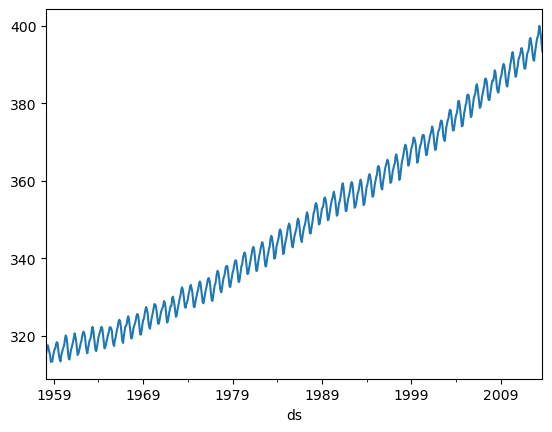

In [8]:
data['co2'].plot()

In [9]:
data.isna().any()

co2                              False
dt                               False
AverageTemperature               False
AverageTemperatureUncertainty    False
Country                          False
dtype: bool

In [10]:

split_index=int(len(data))-36
train_data=data[:split_index]
test_data=data[split_index+1:]


In [12]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    display('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    display(dfoutput)


#define KPSS
def kpss_test(timeseries, trend='c'):
    display('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    display(kpss_output)
    
def stationary_check(timeseries, alpha):
    ad_fuller_results = adfuller(timeseries)
    ad_fuller_pval = ad_fuller_results[1]
    ADF_result = ad_fuller_pval <= alpha
    kpss_test_results = kpss(timeseries)
    kpss_pval = kpss_test_results[1]
    kpss_result = kpss_pval >= alpha
    if (not ADF_result) and (not kpss_result):
        display('the timeseries is non-stationary')
    elif (not ADF_result) and kpss_result:
        display(
            'The series is trend stationary. Trend needs to be removed to make series stationary. The detrended series is checked for stationarity')
    elif ADF_result and (not kpss_result):
        display(
            'The series is difference stationary. Differencing is used to make series stationary. The differenced series is checked for stationarity')
    else:
        display('the timeseries is stationary')

In [13]:
# Using auto_arima to find the best model
auto_model = auto_arima(train_data['AverageTemperature'], seasonal=True, m=12, trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)

# Print the summary of the model
display(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4549.694, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3310.379, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5005.416, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3850.765, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1743.696, Time=3.13 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2049.604, Time=1.60 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=5.98 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=15.68 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3003.872, Time=3.51 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=1926.116, Time=9.11 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=8.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1751.411, Time=4.37 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  631
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -857.981
Date:                              Wed, 08 May 2024   AIC                           1731.962
Time:                                      11:09:21   BIC                           1767.541
Sample:                                  03-01-1958   HQIC                          1745.781
                                       - 09-01-2010                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0049      0.003      1.663      0.096      -0.001       0.011
ar.L1         -0.9517      0.064    -14.851      0.000      -1.077      -0.826
ma.L1          1.1305      0.074     15.258      0.000       0.985       1.276
ma.L2          0.2389      0.053      4.494      0.000       0.135       0.343
ma.L3          0.0824      0.041      2.003      0.045       0.002       0.163
ar.S.L12       0.9997      0.000   6263.708      0.000       0.999       1.000
ma.S.L12      -0.8433      0.025    -33.978      0.000      -0.892      -0.795
sigma2         0.8248      0.040     20.562      0.000       0.746       0.903
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                20.28
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:

n_periods = len(test_data)
X_pred =  auto_model.predict(n_periods=n_periods)


mae_auto_temp = mean_absolute_error(test_data['AverageTemperature'], X_pred)
mse_auto_temp = mean_squared_error(test_data['AverageTemperature'], X_pred)

mape_auto_temp = np.mean(np.abs((test_data['AverageTemperature'] - X_pred) / test_data['AverageTemperature'])) * 100
smape_auto_temp = 100 * np.mean(2 * np.abs(X_pred - test_data['AverageTemperature']) / (np.abs(test_data['AverageTemperature']) + np.abs(X_pred)))

display(f"MAE: {mae_auto_temp}")
display(f"MSE: {mse_auto_temp}")
display(f"MAPE: {mape_auto_temp}%")
display(f"sMAPE: {smape_auto_temp}%")

'MAE: 4.094344782673855'

'MSE: 21.479208061713802'

'MAPE: 26.036071907457604%'

'sMAPE: 22.660290565506074%'

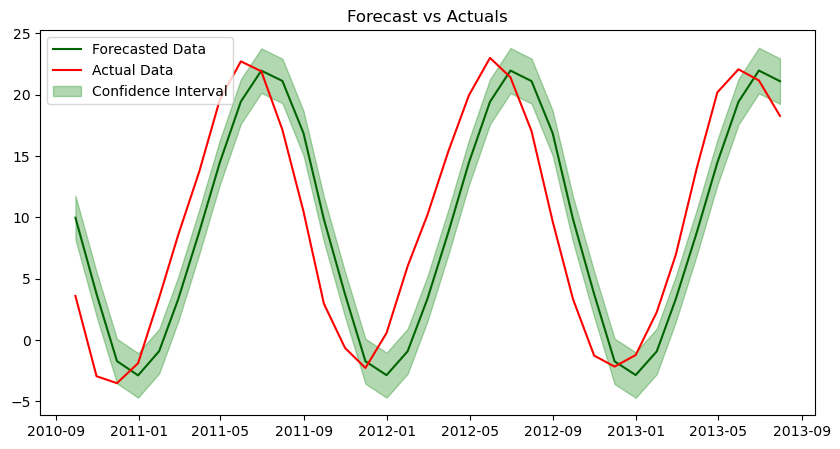

In [15]:

forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

#Assuming you have the actual data for the forecast period in the same order
actual_data = test_data['AverageTemperature'][:n_periods]  # make sure to align your actual data with the forecast period

#Create a time index from your existing data, adjust as needed
forecast_index = pd.date_range(start=train_data.index[-1], periods=n_periods, freq='M')

#Create a DataFrame for forecast data
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)

#Plot the results
plt.figure(figsize=(10, 5))
plt.plot(forecast_index, forecast, color='darkgreen', label='Forecasted Data')
plt.plot(forecast_index, actual_data, color='red', label='Actual Data')
plt.fill_between(forecast_index, 
                 conf_int[:, 0], conf_int[:, 1], 
                 color='green', alpha=0.3, label='Confidence Interval')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [16]:


from pmdarima import auto_arima
# Using auto_arima to find the best SARIMA model
auto_model_include_co2 = auto_arima(train_data['AverageTemperature'], exogenous=train_data['co2'],
                        seasonal=True, m=12, trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)

# Print the summary of the model
display(auto_model_include_co2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  631
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -857.981
Date:                              Wed, 08 May 2024   AIC                           1731.962
Time:                                      11:17:37   BIC                           1767.541
Sample:                                  03-01-1958   HQIC                          1745.781
                                       - 09-01-2010                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0049      0.003      1.663      0.096      -0.001       0.011
ar.L1         -0.9517      0.064    -14.851      0.000      -1.077      -0.826
ma.L1          1.1305      0.074     15.258      0.000       0.985       1.276
ma.L2          0.2389      0.053      4.494      0.000       0.135       0.343
ma.L3          0.0824      0.041      2.003      0.045       0.002       0.163
ar.S.L12       0.9997      0.000   6263.708      0.000       0.999       1.000
ma.S.L12      -0.8433      0.025    -33.978      0.000      -0.892      -0.795
sigma2         0.8248      0.040     20.562      0.000       0.746       0.903
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                20.28
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# Ensure that n_periods matches the actual test data size available
n_periods = len(test_data)

# Generate predictions
X_pred = auto_model_include_co2.predict(n_periods=n_periods)

# Compute metrics
mae_auto_with_co2 = mean_absolute_error(test_data['AverageTemperature'], X_pred)
mse_auto_with_co2 = mean_squared_error(test_data['AverageTemperature'], X_pred)
mape_auto_with_co2 = np.mean(np.abs((test_data['AverageTemperature'] - X_pred) / test_data['AverageTemperature'])) * 100
smape_auto_with_co2 = 100 * np.mean(2 * np.abs(X_pred - test_data['AverageTemperature']) / (np.abs(test_data['AverageTemperature']) + np.abs(X_pred)))

# Display results
display(f"MAE: {mae_auto_with_co2}")
display(f"MSE: {mse_auto_with_co2}")
display(f"MAPE: {mape_auto_with_co2}%")
display(f"sMAPE: {smape_auto_with_co2}%")

'MAE: 4.094344782673855'

'MSE: 21.479208061713802'

'MAPE: 26.036071907457604%'

'sMAPE: 22.660290565506074%'

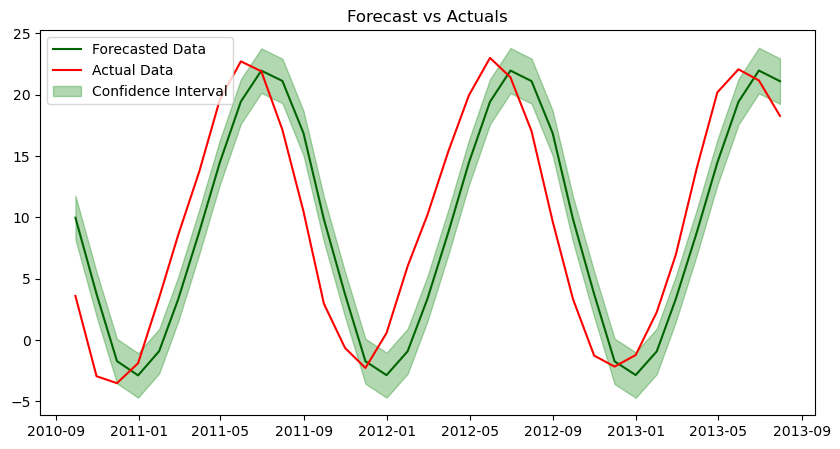

In [18]:

forecast, conf_int = auto_model_include_co2.predict(n_periods=n_periods, return_conf_int=True)

#Assuming you have the actual data for the forecast period in the same order
actual_data = test_data['AverageTemperature'][:n_periods]  # make sure to align your actual data with the forecast period

#Create a time index from your existing data, adjust as needed
forecast_index = pd.date_range(start=train_data.index[-1], periods=n_periods, freq='M')

#Create a DataFrame for forecast data
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)

#Plot the results
plt.figure(figsize=(10, 5))
plt.plot(forecast_index, forecast, color='darkgreen', label='Forecasted Data')
plt.plot(forecast_index, actual_data, color='red', label='Actual Data')
plt.fill_between(forecast_index, 
                 conf_int[:, 0], conf_int[:, 1], 
                 color='green', alpha=0.3, label='Confidence Interval')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [19]:
data

,co2,dt,AverageTemperature,AverageTemperatureUncertainty,Country
ds,,,,,
1958-03-01,315.700,1958-03-01,1.449,0.160,United States
1958-04-01,317.450,1958-04-01,8.144,0.236,United States
1958-05-01,317.510,1958-05-01,14.859,0.301,United States
1958-06-01,316.685,1958-06-01,18.729,0.335,United States
1958-07-01,315.860,1958-07-01,21.098,0.348,United States
...,...,...,...,...,...
2013-05-01,399.980,2013-05-01,14.073,0.178,United States
2013-06-01,398.870,2013-06-01,20.198,0.236,United States
2013-07-01,397.370,2013-07-01,22.074,0.152,United States


In [20]:
data=data.reset_index()

# Rename this column to 'y' for Prophet's expected column name
data['y'] = data['AverageTemperature']
data['ds'] = pd.to_datetime(data['ds']).dt.to_period('M').dt.to_timestamp()
data

,ds,co2,dt,AverageTemperature,AverageTemperatureUncertainty,Country,y
0,1958-03-01,315.700,1958-03-01,1.449,0.160,United States,1.449
1,1958-04-01,317.450,1958-04-01,8.144,0.236,United States,8.144
2,1958-05-01,317.510,1958-05-01,14.859,0.301,United States,14.859
3,1958-06-01,316.685,1958-06-01,18.729,0.335,United States,18.729
4,1958-07-01,315.860,1958-07-01,21.098,0.348,United States,21.098
...,...,...,...,...,...,...,...
662,2013-05-01,399.980,2013-05-01,14.073,0.178,United States,14.073
663,2013-06-01,398.870,2013-06-01,20.198,0.236,United States,20.198
664,2013-07-01,397.370,2013-07-01,22.074,0.152,United States,22.074
665,2013-08-01,395.410,2013-08-01,21.168,0.249,United States,21.168


In [21]:
train_data=data[:split_index]
test_data=data[split_index+1:]

11:18:37 - cmdstanpy - INFO - Chain [1] start processing
11:18:37 - cmdstanpy - INFO - Chain [1] done processing


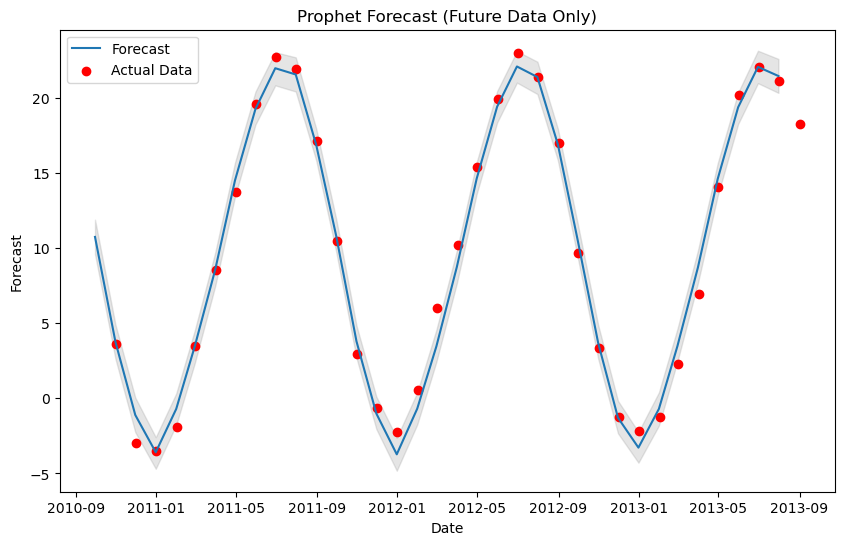

In [22]:

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Generate future dates with the correct monthly frequency and the appropriate number of periods
future_data = model.make_future_dataframe(periods=len(test_data), freq='M')

# Check future_data to ensure it is within bounds
forecast_data = model.predict(future_data)
# Filter the forecast to only include dates after the last date in the training data
max_train_date = train_data['ds'].max()
forecast_data_future_only = forecast_data[forecast_data['ds'] > max_train_date]

# Plot the forecast data for future dates only
plt.figure(figsize=(10, 6))
plt.plot(forecast_data_future_only['ds'], forecast_data_future_only['yhat'], label='Forecast')
plt.fill_between(forecast_data_future_only['ds'], forecast_data_future_only['yhat_lower'], forecast_data_future_only['yhat_upper'], color='gray', alpha=0.2)

plt.scatter(test_data['ds'], test_data['y'], color='red', label='Actual Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Forecast')
plt.title('Prophet Forecast (Future Data Only)')
plt.show()

In [23]:
def plot_plotly_modified(
    m, 
    fcst, 
    test_x=[], 
    test_y=[], 
    lbl_list=['Actual Test'], 
    color_list=[], 
    size_list=[], 
    transform=None,
    transform_test=False,
    show_changepoints=False
):
    '''
    Parameters
    ----------
    m : fbprophet model
        model
    fcst : fbprophet forecast
        forecast
    test_x : list or pandas series
        Test data to overlay x value
    test_y : list or pandas series
        Test data to overlay y value
    transform : None/function
        If provided, transform the y values using this function
    show_changepoints : bool
        If True, plot the change points on the forecast plot
    '''
    
    m = copy.deepcopy(m)
    fcst = copy.deepcopy(fcst)
    
    if transform:
        m.history['y'] = transform(m.history['y'])
        fcst['yhat_lower'] = transform(fcst['yhat_lower'])
        fcst['yhat'] = transform(fcst['yhat'])
        fcst['yhat_upper'] = transform(fcst['yhat_upper'])
        
        if 'cap' in fcst:
            fcst['cap'] = transform(fcst['cap'])
        if 'floor' in fcst:
            fcst['floor'] = transform(fcst['floor'])
        if 'trend' in fcst:
            fcst['trend'] = transform(fcst['trend'])
    
    py.init_notebook_mode()
    fig1 = plot_plotly(m, fcst)
    default_colors = ['red', 'orange', 'blue', 'green', 'purple', 'brown', 'grey', 'black']
    
    if not isinstance(test_x, list): test_x = [test_x]
    if not isinstance(test_y, list): test_y = [test_y]
    if isinstance(color_list, str): color_list = [color_list]
    if isinstance(lbl_list, str): lbl_list = [lbl_list]
    if isinstance(size_list, (str, int, float)): size_list = [size_list]
    
    trace_list = []
    for i in range(len(test_x)):
        lbl = lbl_list[i] if len(lbl_list) > i else f'trace_{i}'
        clr = color_list[i] if len(color_list) > i else default_colors.pop(0)
        sz = float(size_list[i]) if len(size_list) > i else 4
        
        x = test_x[i]
        y = test_y[i]
        if transform_test and transform:
            y = pd.Series(y).apply(transform)
        
        trace = go.Scatter(
            x=x, 
            y=y,
            name=lbl,
            mode='markers', 
            marker=dict(color=clr, size=sz)
        )
        trace_list.append(trace)
    
    if show_changepoints:
        changepoint_trace = go.Scatter(
            x=m.changepoints,
            y=fcst.loc[fcst['ds'].isin(m.changepoints), 'yhat'],
            name='Changepoints',
            mode='markers',
            marker=dict(color='red', size=5, symbol='x')  # symbol changed to 'line-ns'
        )
        trace_list.append(changepoint_trace)

    fig1.add_traces(trace_list)
    fig1.layout.update(title="Forecast plot with Test Data and Changepoints" if show_changepoints else "Forecast plot with Test Data")
    py.iplot(fig1)

11:18:46 - cmdstanpy - INFO - Chain [1] start processing
11:18:46 - cmdstanpy - INFO - Chain [1] done processing


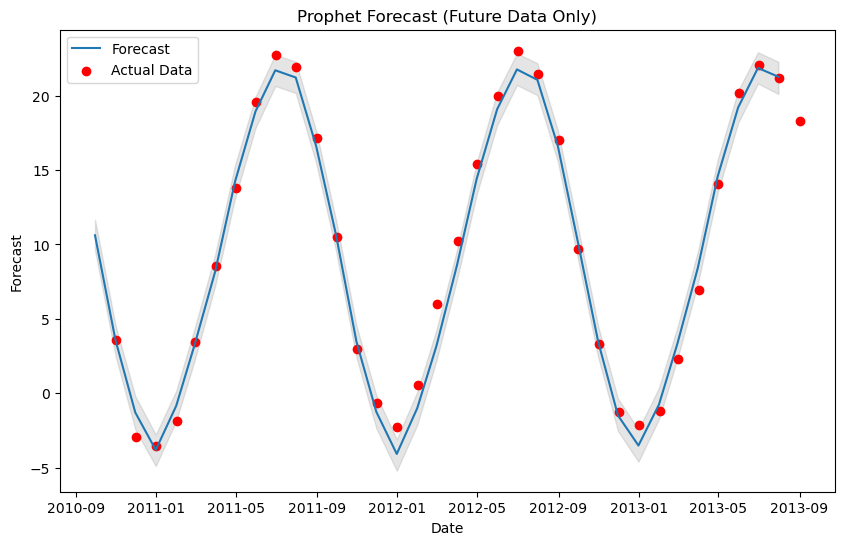

In [24]:

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_regressor('co2') 
model.fit(train_data)
futures_data = model.make_future_dataframe(len(test_data), freq='m')
future_data['co2']=data['co2']
forecast_data = model.predict(future_data)
# Filter the forecast to only include dates after the last date in the training data
max_train_date = train_data['ds'].max()
forecast_data_future_only = forecast_data[forecast_data['ds'] > max_train_date]

# Plot the forecast data for future dates only
plt.figure(figsize=(10, 6))
plt.plot(forecast_data_future_only['ds'], forecast_data_future_only['yhat'], label='Forecast')
plt.fill_between(forecast_data_future_only['ds'], forecast_data_future_only['yhat_lower'], forecast_data_future_only['yhat_upper'], color='gray', alpha=0.2)

plt.scatter(test_data['ds'], test_data['y'], color='red', label='Actual Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Forecast')
plt.title('Prophet Forecast (Future Data Only)')
plt.show()